<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/FastText_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet
!pip install gensim==3.8.3 --quiet
!pip install compress-fasttext==0.0.1 --quiet

In [81]:
import wget
import os
import sys
import re
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import compress_fasttext
import gensim

# **Get cleaned dataset**

In [82]:
PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [83]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
7186,ну для вакансия где важно чтоб соискатель не с...,0
7566,да блин обычный практика юрист иск готовить по...,0
9320,у мы быть другой развлечение забрать одежда ра...,0
5592,у ебнуть аутист до сей пора кровавый пена ведь...,1
13662,вы там всё дебил кубанойдия свой один по встре...,1
10217,у негр пятка не чёрный,1
9133,тогда антибиотик без рецепт отпускаться аптека...,0
6593,номер возорт ах ты возорт эдакий,1
3249,ни честь ни доблесть пьянь тупость куча говно ...,1
8534,мб поделить на впечатлять,0


In [84]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


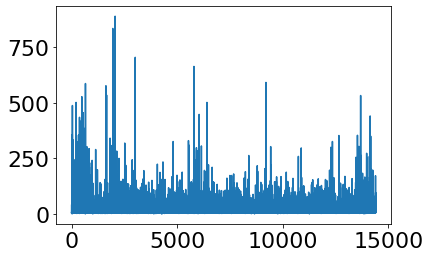

In [85]:
print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [86]:
sentences = df.comment.values
labels = df.toxic.values

In [87]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25

(11529,)


In [88]:
X_train.shape

(8646,)

[FastText Embedding by David Dale](https://github.com/avidale/compress-fasttext/releases/tag/v0.0.1)

In [89]:
import compress_fasttext
# url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'

# print(small_model['спасибо'])
# # [ 0.26762889  0.35489027 ...  -0.06149674] # a 300-dimensional vector
# print(small_model.most_similar('котенок'))


# import fasttext
url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'
PATH_FASTTEXT = 'ft_freqprune_100K_20K_pq_300.bin'



if not os.path.exists(PATH_FASTTEXT):
    wget.download(url)
    
# ft = fasttext.load_model('ft_freqprune_100K_20K_pq_300.bin')

ft = gensim.models.fasttext.FastTextKeyedVectors.load('ft_freqprune_100K_20K_pq_300.bin')
print(ft['jhsfbjhsg'].shape)


(300,)


In [90]:
PAD_TOKEN = '<pad>'

In [91]:
def vectorize_sentence(sentence: str, vectorizer=ft, pad_token = PAD_TOKEN, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [vectorizer.get_vector(t) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [vectorizer[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [92]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [93]:
sequence_length=32
sequence_length

32

# Word Vectorizer

In [94]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_val = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_val.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))

# X_train = np.array(list(
#     map(fasttext_sentence_vectorizer, X_train.flatten())
# ))

# X_test = np.array(list(
#     map(fasttext_sentence_vectorizer, X_test.flatten())
# ))

In [95]:
X_train.shape

(8646, 32, 300)

In [96]:
ft[PAD_TOKEN].shape[0]

300

In [97]:
DIMENSION_EMBEDDING=ft[PAD_TOKEN].shape[0]

# Build model  BiLSTM

Model: "FASTTEXT-RusVectores_CNN-GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 256)           230656    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 387,201
Trainable params

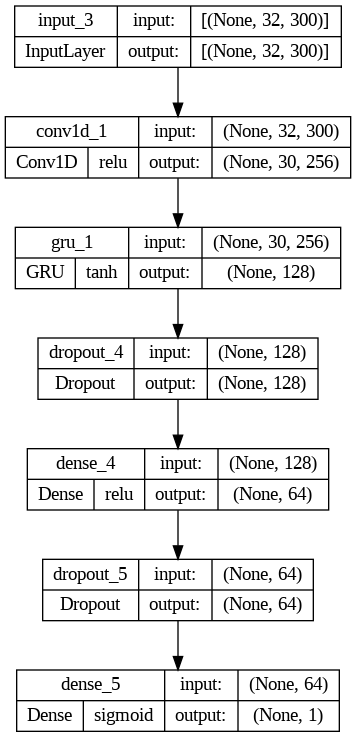

In [98]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Conv1D,GlobalMaxPool1D,SpatialDropout1D,GRU
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

MODEL_NAME = 'FASTTEXT-RusVectores_CNN-GRU'
SEED = 42
SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GRU(128, dropout=0.3, recurrent_dropout=0.1),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [99]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
17/17 [==============================] - 14s 472ms/step - loss: 0.7079 - tp: 1003.0000 - fp: 1820.0000 - tn: 3914.0000 - fn: 1909.0000 - accuracy: 0.5687 - precision: 0.3553 - recall: 0.3444 - auc: 0.5401 - prc: 0.3619 - val_loss: 0.6625 - val_tp: 781.0000 - val_fp: 1226.0000 - val_tn: 682.0000 - val_fn: 194.0000 - val_accuracy: 0.5075 - val_precision: 0.3891 - val_recall: 0.8010 - val_auc: 0.5891 - val_prc: 0.3879
Epoch 2/50
17/17 [==============================] - 8s 470ms/step - loss: 0.6823 - tp: 1476.0000 - fp: 2435.0000 - tn: 3299.0000 - fn: 1436.0000 - accuracy: 0.5523 - precision: 0.3774 - recall: 0.5069 - auc: 0.5776 - prc: 0.3846 - val_loss: 0.6747 - val_tp: 846.0000 - val_fp: 1349.0000 - val_tn: 559.0000 - val_fn: 129.0000 - val_accuracy: 0.4873 - val_precision: 0.3854 - val_recall: 0.8677 - val_auc: 0.6083 - val_prc: 0.4089
Epoch 3/50
17/17 [==============================] - 6s 368ms/step - loss: 0.6704 - tp: 1561.0000 - fp: 2426.0000 - tn: 3308.0000 - fn: 1351.0

**Save Model**

In [100]:
model.save(MODEL_NAME)

In [101]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 1s 11ms/step


In [102]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

**Model evaluation**

In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
  print("Recall:", score_to_percent(recall_score(y_test, pred)))
  print("Precision:",score_to_percent(precision_score(y_test, pred)))
  print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 88.0 %
Recall: 81.47 %
Precision: 81.64 %
F1-score: 81.56 % 

precision: 0.8635106246455801, recall: 0.8631095596839296, f1score: 0.8633095082793889
              precision    recall  f1-score   support

           0     0.9106    0.9115    0.9111      1944
           1     0.8164    0.8147    0.8156       939

    accuracy                         0.8800      2883
   macro avg     0.8635    0.8631    0.8633      2883
weighted avg     0.8799    0.8800    0.8800      2883

True Negatives:  1772
False Positives:  172
False Negatives:  174
True Positives:  765


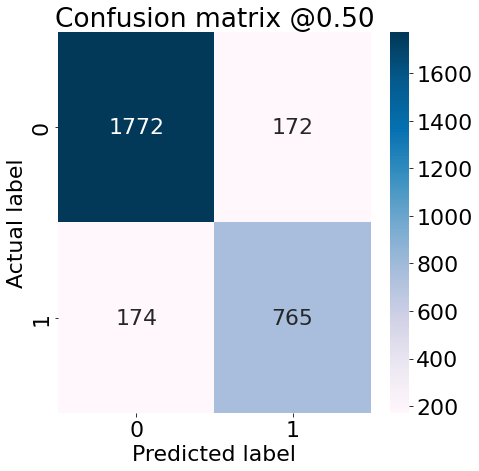

In [104]:
plot_cm(y_test, pred)

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

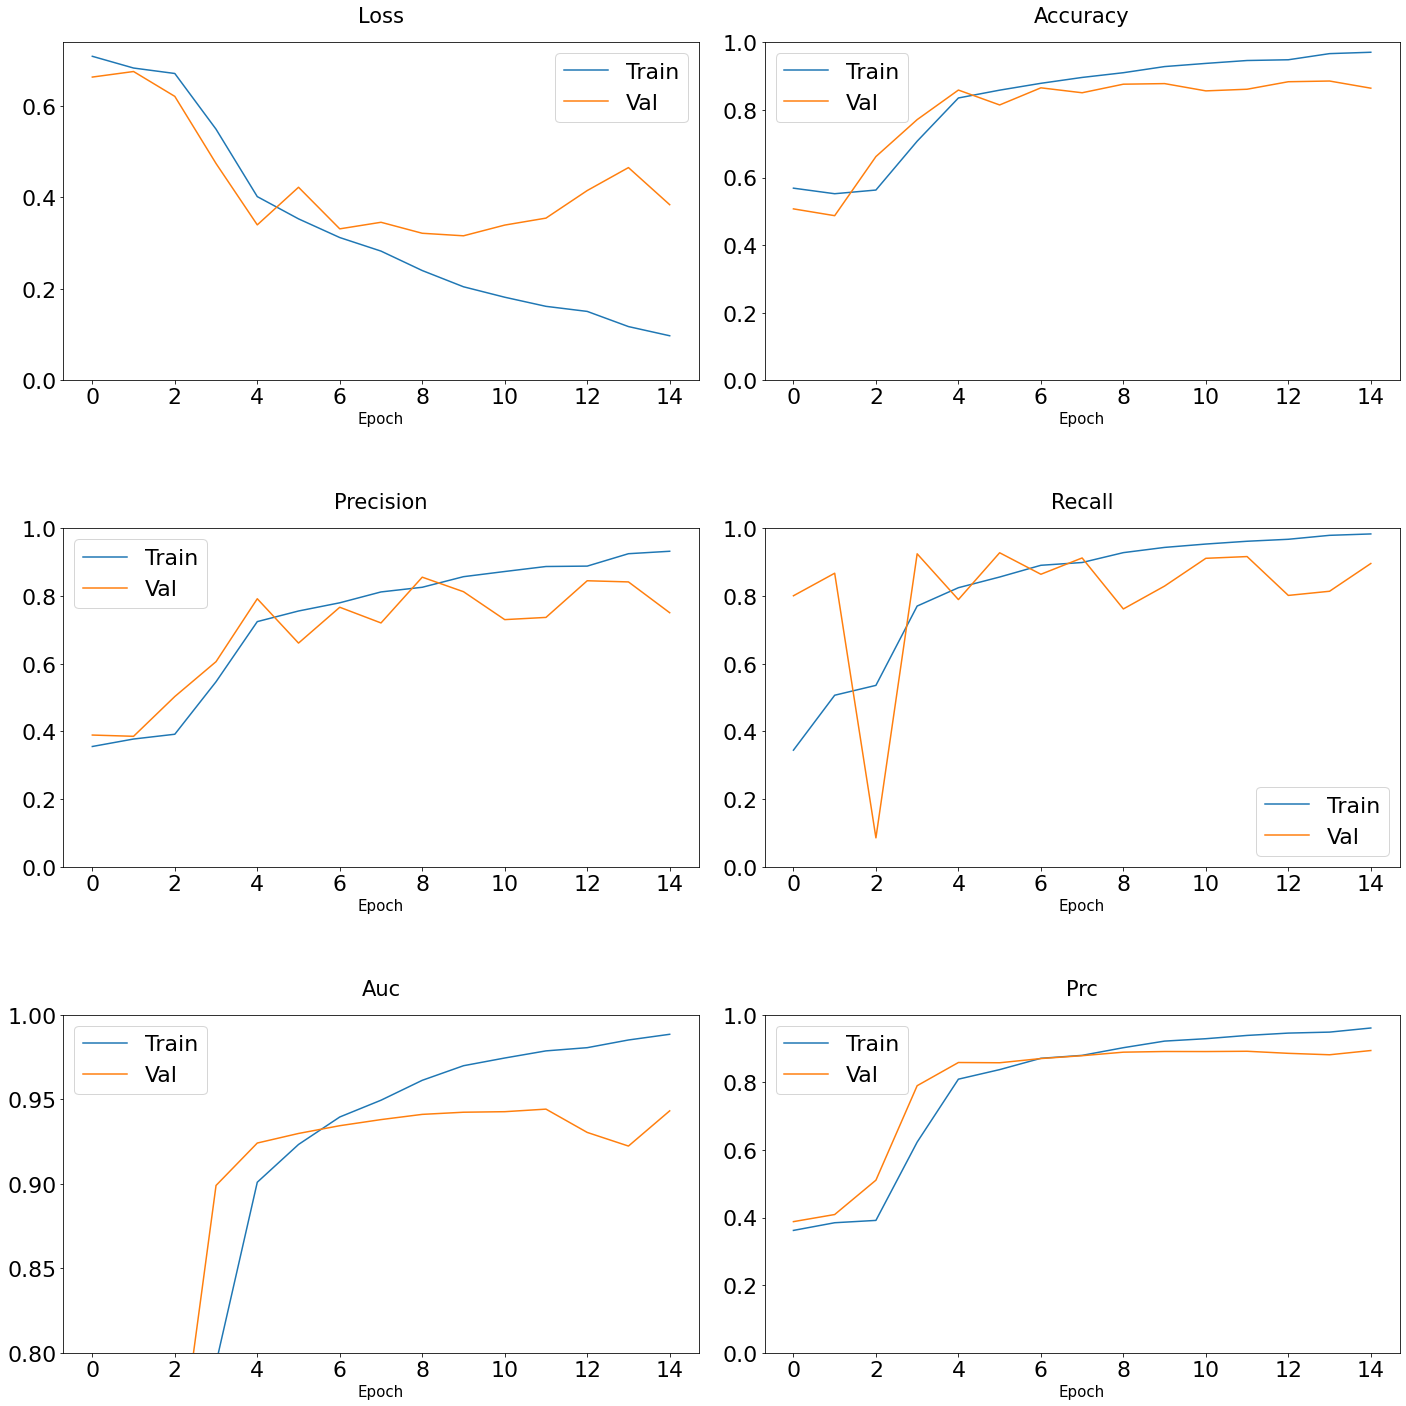

In [107]:
plot_metrics(history)